<center> <h1> Freesound Audio Tagging </h1> </center>

# 5. Modelling

### Importing Libraries

In [1]:
# General imports
import numpy as np
import pandas as pd
import scipy
import datetime
import zipfile
import joblib
import shutil
import os
import gc

# Machine Learning imports
from sklearn.metrics import label_ranking_average_precision_score
from sklearn.model_selection import train_test_split

# Visualization imports
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")

# Deep Learning Imports
import tensorflow as tf
from tensorflow.keras import models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, Callback 
from tensorflow.keras.layers import  Input, Dense, LSTM, Convolution1D, MaxPool1D, Dropout, GlobalMaxPool1D
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.metrics import Metric
from tensorflow.keras.backend import squeeze

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Setting seeds for replicable results
tf.random.set_seed(21)
np.random.seed(21)

In [4]:
TRAIN_DIR = r'preprocessed_train_data/'
VAL_DIR = r'preprocessed_val_data/'

In [5]:
df_train = pd.read_csv(r'df_train.csv')
df_train=df_train[['fname', 'labels']]
df_train.to_csv('df_train.csv', index=False)

df_val = pd.read_csv(r'df_val.csv')
df_val=df_val[['fname', 'labels']]
df_val.to_csv('df_val.csv', index=False)

#### Creating Config Class

In [6]:
# Config class is used to share global parameters across various functions
class Config():
    def __init__(self,
                 sampling_rate=None,
                 audio_duration=None,
                 n_classes=80):
        
        self.sampling_rate = sampling_rate
        self.audio_duration = audio_duration
        self.n_classes = n_classes
        self.audio_length = self.sampling_rate * self.audio_duration
        self.dim = (self.audio_length, 1)

In [7]:
config = Config(sampling_rate=16000, audio_duration=15)

#### Label Encoding

In [9]:
# class_map is a hash table like mapping which assigns a unique integer between 0-79 to each of the unique class label
LABELS = joblib.load(r'labels.joblib')
index_list = list(range(len(LABELS)))
label_dict = {'Numeric_Label' : index_list, 'Text_Label' : LABELS}
class_map_df = pd.DataFrame(label_dict)
class_map_df.to_csv(r'class_map.csv', header=False, index=False)

### Input pipeline (creation of train and validation dataset)

In [10]:
def get_audio(clip_path):
    '''
    Read the contents of the clip_path which is a .wav file using scipy.io.read(), convert it into a tensor and them return it
    Input ->
    clip_path: Path to the .wav file to be read
    Output ->
    Tensor contating the contents of the .wav file
    '''
    clip_path = clip_path.numpy()
    _, data = scipy.io.read(clip_path)
    return tf.constant(data)

def clip_to_waveform(clip, clip_dir=None):
    """
    Decodes a WAV clip into a waveform tensor
    This function is used as a wrapper for the above function because scipy can read only from strings and not tensors, so,
    tf.py_function() is used to enable eager execution and convert tensor to numpy array
    
    Input ->
    clip: Filename of the preprocessed .wav file to be read ("preprocessed_file1.wav")
    clip_dir: Parent directory containing the above .wav file (preprocessed_train_dir)
    
    Output ->
    Tensor representation of the preprocessed .wav file in the appropriate dimensions
    """
    clip_path = tf.strings.join([clip_dir, clip], separator=os.sep)
    clip_data = tf.py_function(get_audio, [clip_path], [tf.float32])
    return tf.reshape(clip_data, (config.audio_length, 1)) 


def generating_features_and_labels(csv_record,
                                   clip_dir=None,
                                   label_class_index_table=None,
                                   num_classes=None):
    """
    Description -> Creates a tuple of (data, label) from a training record

    Inputs ->
    csv_record: a line from a training CSV file downloaded from Kaggle
    clip_dir: path to a directory containing clips referenced by csv_record
    label_class_index_table: a lookup table that represents the class map
    num_classes: number of classes in the class map

    Output ->
    features: Tensor containing a data read from preprocessed .wav file
    labels: Tensor containing corresponding labels in 1-hot format
    
    """
    # clip is the filename such as "filename1.wav"
    # labels_str is the string of all labels corresponding to that filename eg., "bike,vroom,accelarate"
    [clip, labels_str] = tf.io.decode_csv(csv_record, record_defaults=[[''],['']])
    
    # features are the windowed log mel spectrogram examples
    features = clip_to_waveform(clip, clip_dir=clip_dir)
    
    # We split all the labels by comma
    clip_labels = tf.strings.split([labels_str], sep=',').values
    
    # Obtain the corresponding indices from the lookup table
    class_indices = label_class_index_table.lookup(clip_labels)
    
    # One Hot Encode the class_indices
    label_onehots = tf.one_hot(indices=class_indices, depth=num_classes)
    labels = tf.math.reduce_max(label_onehots, axis=[0], keepdims=False)
    
    return features, labels

def get_class_map(class_map_path):
    """
    Description -> Constructs a class label lookup table from a class map
    
    Input ->
    class_map_path: Path to the class_map.csv file which contains the mapping of each unqiue class label to an integer from 0-79
    
    Output ->
    label_class_index_table: Lookup table mapping each class label to a unique integer
    num_classes: Total number of unique classes
    """
    label_class_index_table = tf.lookup.StaticHashTable(tf.lookup.TextFileInitializer(filename=class_map_path,
                                                                                      key_dtype=tf.string,
                                                                                      key_index=1,
                                                                                      value_dtype=tf.int32,
                                                                                      value_index=0,
                                                                                      delimiter=','),
                                                        default_value=-1)
    num_classes = len(open(class_map_path).readlines())
    return label_class_index_table, num_classes

In [14]:
#Ref: https://stackoverflow.com/questions/46263963/how-to-map-a-function-with-additional-parameter-using-the-new-dataset-api-in-tf1
AUTOTUNE = tf.data.experimental.AUTOTUNE
label_class_index_table, num_classes = get_class_map(class_map_path)

# Load the training dataset from train_curated.csv file
train_dataset = tf.data.TextLineDataset(train_csv_path)

# Skip the header
train_dataset = train_dataset.skip(1)

train_dataset = train_dataset.map(lambda x: generating_features_and_labels(x,
                                                                           clip_dir=TRAIN_DIR,
                                                                           label_class_index_table=label_class_index_table,
                                                                           num_classes=num_classes),
                                  num_parallel_calls=AUTOTUNE)

val_dataset = tf.data.TextLineDataset(val_csv_path)
val_dataset = val_dataset.skip(1)
val_dataset = val_dataset.map(lambda x: generating_features_and_labels(x,
                                                                       clip_dir=VAL_DIR,
                                                                       label_class_index_table=label_class_index_table,
                                                                       num_classes=num_classes),
                              num_parallel_calls=AUTOTUNE)

In [15]:
for i in train_dataset:
    print("Shape of data = ", tf.shape(i[0]))
    print("Shape of output label = ", tf.shape(i[1]))
    print("Example data point -> \n", i)
    break

Shape of data =  tf.Tensor([240000      1], shape=(2,), dtype=int32)
Shape of output label =  tf.Tensor([80], shape=(1,), dtype=int32)
Example data point -> 
 (<tf.Tensor: shape=(240000, 1), dtype=float32, numpy=
array([[-4.5487093e-04],
       [-6.8455690e-04],
       [-9.0208353e-04],
       ...,
       [-3.2179447e-05],
       [-2.9683917e-05],
       [-4.5162695e-05]], dtype=float32)>, <tf.Tensor: shape=(80,), dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>)


### Code for the performance metric: LWLRAP

In [15]:
# Reference implementation from: https://colab.research.google.com/drive/1AgPdhSp7ttY18O3fEoHOQKlt_3HJDLi8
def _lwlrap_sklearn(truth, scores):
    '''
    Description -> Return the Label Weighted Label Ranking Average Precision (LWLRAP) of the given true and predicted
    class labels
    
    Inputs ->
    truth: OHE Vector of truth class label
    scores: NumPy array of predictions
    
    Output -> LWLRAP score
    '''
    sample_weight = np.sum(truth > 0, axis=1)
    nonzero_weight_sample_indices = np.flatnonzero(sample_weight > 0)
    overall_lwlrap = label_ranking_average_precision_score(
        truth[nonzero_weight_sample_indices, :] > 0, 
        scores[nonzero_weight_sample_indices, :], 
        sample_weight=sample_weight[nonzero_weight_sample_indices])
    return overall_lwlrap


def _one_sample_positive_class_precisions(example):
    y_true, y_pred = example
    retrieved_classes = tf.argsort(y_pred, direction='DESCENDING')
    class_rankings = tf.argsort(retrieved_classes)
    retrieved_class_true = tf.gather(y_true, retrieved_classes)
    retrieved_cumulative_hits = tf.math.cumsum(tf.cast(retrieved_class_true, tf.float32))

    idx = tf.where(y_true)[:, 0]
    i = tf.boolean_mask(class_rankings, y_true)
    r = tf.gather(retrieved_cumulative_hits, i)
    c = 1 + tf.cast(i, tf.float32)
    precisions = r / c
    dense = tf.scatter_nd(idx[:, None], precisions, [y_pred.shape[0]])
    return dense

class LWLRAP(Metric):
    def __init__(self, num_classes, name='lwlrap'):
        super().__init__(name=name)

        self._precisions = self.add_weight(
            name='per_class_cumulative_precision',
            shape=[num_classes],
            initializer='zeros')

        self._counts = self.add_weight(
            name='per_class_cumulative_count',
            shape=[num_classes],
            initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        precisions = tf.map_fn(
            fn=_one_sample_positive_class_precisions,
            elems=(y_true, y_pred),
            dtype=(tf.float32))

        increments = tf.cast(precisions > 0, tf.float32)
        total_increments = tf.reduce_sum(increments, axis=0)
        total_precisions = tf.reduce_sum(precisions, axis=0)

        self._precisions.assign_add(total_precisions)
        self._counts.assign_add(total_increments)        

    def result(self):
        per_class_lwlrap = self._precisions / tf.maximum(self._counts, 1.0)
        per_class_weight = self._counts / tf.reduce_sum(self._counts)
        overall_lwlrap = tf.reduce_sum(per_class_lwlrap * per_class_weight)
        return overall_lwlrap

    def reset_states(self):
        self._precisions.assign(self._precisions * 0)
        self._counts.assign(self._counts * 0)

## Basline Model (Single layered LSTM)

We define a very basic baseline model (1-layered LSTM) which will be used to compare the performance of future models

In [8]:
def get_baseline_lstm_model():
    '''
    Description -> Return the compiled LSTM Model
    Input -> None
    Output -> Compiled Baseline LSTM Model
    '''
    nclass = config.n_classes
    input_length = config.audio_length
    inp = Input(shape=(input_length, 1))
    x = tf.keras.layers.LSTM(16)(inp)
    out = Dense(nclass, activation='sigmoid')(x)
    model = models.Model(inputs=inp, outputs=out)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[LWLRAP(config.n_classes)])
    return model

In [17]:
model = get_baseline_lstm_model()
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 240000, 1)]       0         
_________________________________________________________________
lstm (LSTM)                  (None, 16)                1152      
_________________________________________________________________
dense (Dense)                (None, 80)                1360      
Total params: 2,512
Trainable params: 2,512
Non-trainable params: 0
_________________________________________________________________


In [18]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
checkpoint = ModelCheckpoint(filepath='weights_{epoch}-loss_{loss:.4f}_lwlrap_{lwlrap:.4f}.h5',
                             verbose=0, save_weights_only=True)

callbacks_list = [checkpoint, tensorboard_callback]

In [19]:
# Creating mini batches of size 64
batch_size = 64
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.prefetch(AUTOTUNE)

val_dataset = val_dataset.batch(batch_size)
val_dataset = val_dataset.prefetch(AUTOTUNE)

In [20]:
# Training the model for 10 epochs

history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    callbacks=callbacks_list,
                    verbose=2,
                    epochs=10)

Epoch 1/10
55/55 - 482s - loss: 5.0678 - lwlrap: 0.0657 - val_loss: 5.0667 - val_lwlrap: 0.0634
Epoch 2/10
55/55 - 426s - loss: 5.0666 - lwlrap: 0.0699 - val_loss: 5.0668 - val_lwlrap: 0.0656
Epoch 3/10
55/55 - 427s - loss: 5.0713 - lwlrap: 0.0689 - val_loss: 5.0841 - val_lwlrap: 0.0652
Epoch 4/10
55/55 - 426s - loss: 5.0751 - lwlrap: 0.0655 - val_loss: 5.0935 - val_lwlrap: 0.0624
Epoch 5/10
55/55 - 427s - loss: 5.0768 - lwlrap: 0.0689 - val_loss: 5.0869 - val_lwlrap: 0.0604
Epoch 6/10
55/55 - 428s - loss: 5.0747 - lwlrap: 0.0665 - val_loss: 5.0811 - val_lwlrap: 0.0600
Epoch 7/10
55/55 - 426s - loss: 5.0723 - lwlrap: 0.0654 - val_loss: 5.0779 - val_lwlrap: 0.0602
Epoch 8/10
55/55 - 428s - loss: 5.0711 - lwlrap: 0.0649 - val_loss: 5.0768 - val_lwlrap: 0.0611
Epoch 9/10
55/55 - 426s - loss: 5.0703 - lwlrap: 0.0651 - val_loss: 5.0763 - val_lwlrap: 0.0607
Epoch 10/10
55/55 - 425s - loss: 5.0698 - lwlrap: 0.0651 - val_loss: 5.0761 - val_lwlrap: 0.0607


### Conclusion:
The baseline model has an LWLRAP score close to 0 which is the minimum score and thus it means, we've to train a sufficiently complex model for this task.

## Model 1: 1-D CNN

### Generating the train and validation dataset

In [26]:
train_dataset = tf.data.TextLineDataset(train_csv_path)
train_dataset = train_dataset.skip(1)
train_dataset = train_dataset.map(lambda x: record_to_labeled_log_mel_examples(x,
                                                                               clip_dir=TRAIN_DIR,
                                                                               label_class_index_table=label_class_index_table,
                                                                               num_classes=num_classes),
                                  num_parallel_calls=AUTOTUNE)

val_dataset = tf.data.TextLineDataset(val_csv_path)
val_dataset = val_dataset.skip(1)
val_dataset = val_dataset.map(lambda x: record_to_labeled_log_mel_examples(x,
                                                                           clip_dir=VAL_DIR,
                                                                           label_class_index_table=label_class_index_table,
                                                                           num_classes=num_classes),
                              num_parallel_calls=AUTOTUNE)

In [27]:
batch_size = 64
train_dataset = train_dataset.batch(batch_size)
val_dataset = val_dataset.batch(batch_size)

### Defining the model architecture

In [28]:
def get_1d_cnn_model():
    '''
    Description -> Return the 1-D CNN Model of the below architecture compiled using "Adam" optimizer with a categorical
    cross entropy loss function
    Input -> None
    Output -> Compiled 1-D CNN Model
    '''
    input_shape = config.dim
    inp = Input(shape=input_shape)
    
    x = Convolution1D(16, 9, activation='relu', padding="valid")(inp)
    x = Convolution1D(16, 9, activation='relu', padding="valid")(x)
    x = MaxPool1D(16)(x)
    x = Dropout(rate=0.1)(x)
    
    x = Convolution1D(32, 3, activation='relu', padding="valid")(x)
    x = Convolution1D(32, 3, activation='relu', padding="valid")(x)
    x = MaxPool1D(4)(x)
    x = Dropout(rate=0.1)(x)
    
    x = Convolution1D(32, 3, activation='relu', padding="valid")(x)
    x = Convolution1D(32, 3, activation='relu', padding="valid")(x)
    x = MaxPool1D(4)(x)
    x = Dropout(rate=0.1)(x)
    
    x = Convolution1D(256, 3, activation='relu', padding="valid")(x)
    x = Convolution1D(256, 3, activation='relu', padding="valid")(x)
    x = GlobalMaxPool1D()(x)
    x = Dropout(rate=0.2)(x)

    x = Dense(64, activation='relu')(x)
    x = Dense(1028, activation='relu')(x)
    out = Dense(80, activation='sigmoid')(x)
    
    model = models.Model(inputs=inp, outputs=out)
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=[LWLRAP(config.n_classes)])
    
    return model

In [19]:
# Creating TF callbacks to get TensorBoard logs and to save model weights after every epoch
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
checkpoint = ModelCheckpoint(filepath='weights_{epoch}-loss_{loss:.4f}_lwlrap_{lwlrap:.4f}.h5',
                             verbose=1, save_weights_only=True)
callbacks_list = [checkpoint, tensorboard_callback]

# Creating a model instance
model = get_1d_cnn_model()
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 240000, 1)]       0         
_________________________________________________________________
conv1d (Conv1D)              (None, 239992, 16)        160       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 239984, 16)        2320      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 14999, 16)         0         
_________________________________________________________________
dropout (Dropout)            (None, 14999, 16)         0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 14997, 32)         1568      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 14995, 32)        

In [20]:
# Training the model for 50 epochs

history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    callbacks=callbacks_list,
                    verbose=2,
                    epochs=50)

Epoch 1/50
55/55 - 24s - loss: 5.0053 - lwlrap: 0.0840 - val_loss: 4.9608 - val_lwlrap: 0.0975
Epoch 2/50
55/55 - 22s - loss: 4.8237 - lwlrap: 0.1109 - val_loss: 4.7099 - val_lwlrap: 0.1207
Epoch 3/50
55/55 - 22s - loss: 4.6494 - lwlrap: 0.1286 - val_loss: 4.6168 - val_lwlrap: 0.1356
Epoch 4/50
55/55 - 23s - loss: 4.5568 - lwlrap: 0.1441 - val_loss: 4.5740 - val_lwlrap: 0.1440
Epoch 5/50
55/55 - 22s - loss: 4.4663 - lwlrap: 0.1588 - val_loss: 4.4023 - val_lwlrap: 0.1673
Epoch 6/50
55/55 - 22s - loss: 4.4021 - lwlrap: 0.1760 - val_loss: 4.3453 - val_lwlrap: 0.2001
Epoch 7/50
55/55 - 22s - loss: 4.2824 - lwlrap: 0.1977 - val_loss: 4.1543 - val_lwlrap: 0.2344
Epoch 8/50
55/55 - 22s - loss: 4.0526 - lwlrap: 0.2515 - val_loss: 3.9764 - val_lwlrap: 0.2708
Epoch 9/50
55/55 - 23s - loss: 3.8745 - lwlrap: 0.2959 - val_loss: 3.8776 - val_lwlrap: 0.2924
Epoch 10/50
55/55 - 22s - loss: 3.7120 - lwlrap: 0.3235 - val_loss: 3.7962 - val_lwlrap: 0.3153
Epoch 11/50
55/55 - 22s - loss: 3.5902 - lwlrap: 

### Cross validation curve for 1-D CNN Model

### Loss curve

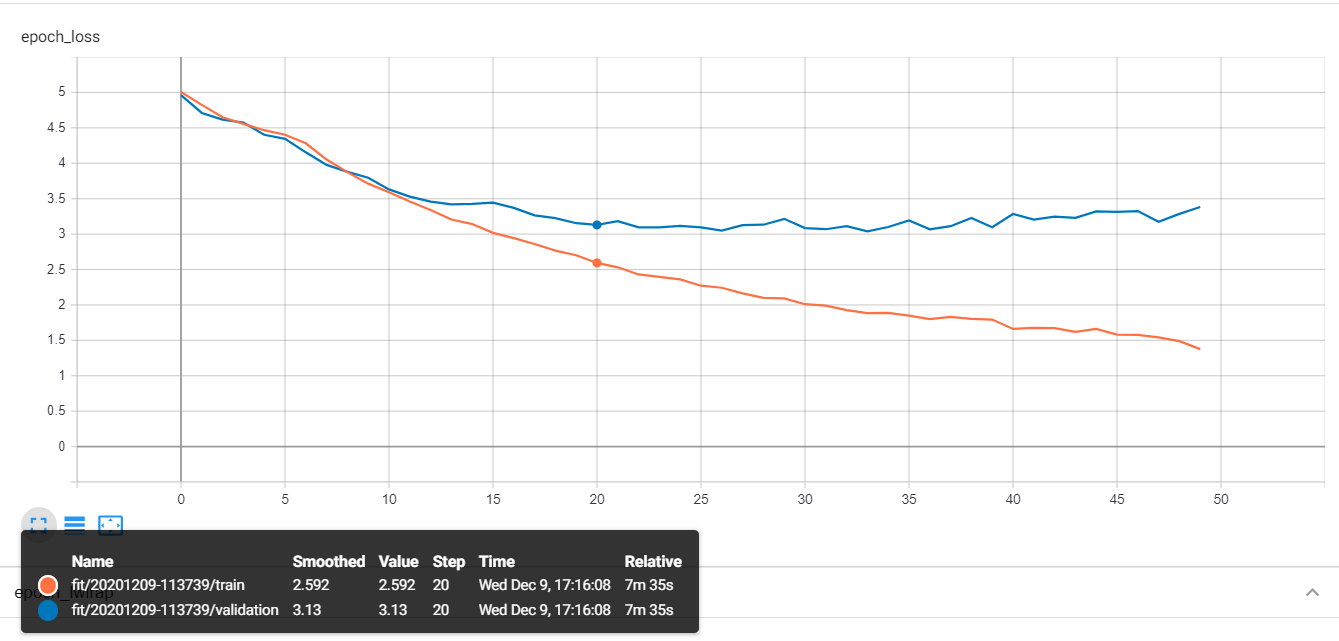

### LWLRAP Curve

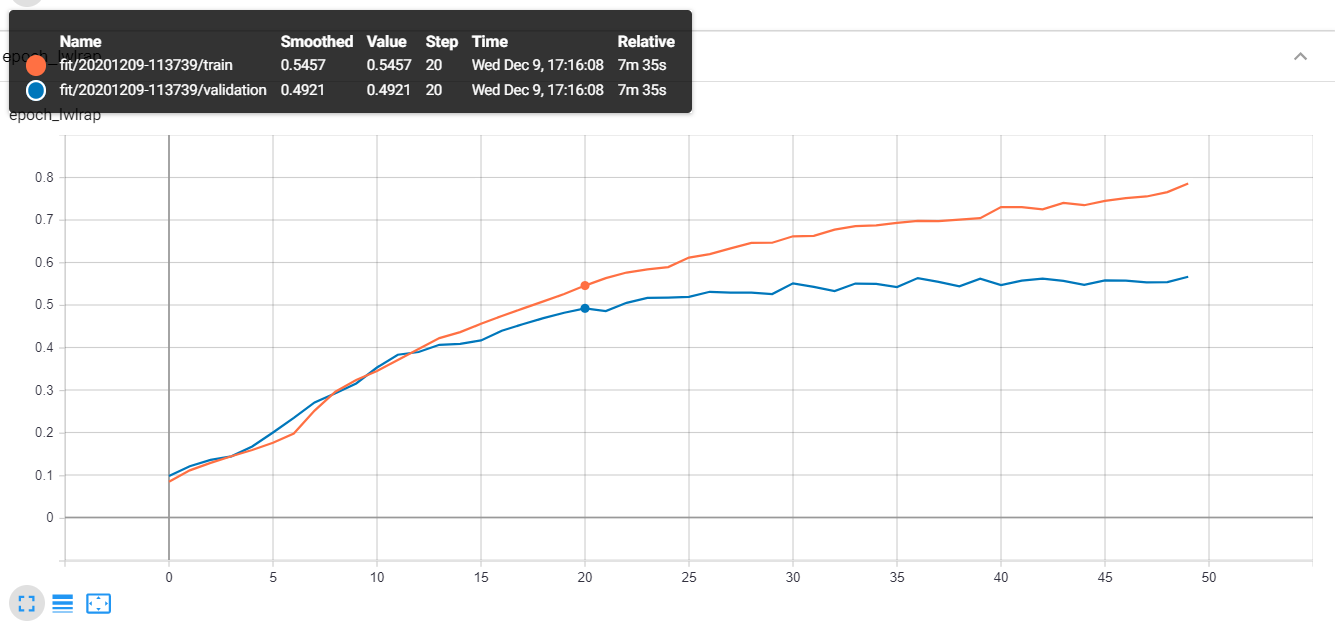

From the curves, 20 epochs seem to be enough as after that loss curve starts flattening and the gap between train and validation loss starts increasing

### Conclusion:
We get very good results as compared to the baseline model. The difference between the training and validation LWLRAP is also not very significant and hence we can conclude the model is not overfitting and performing good on the validation dataset as well.

## Performance on test dataset

In [28]:
df_test = pd.read_csv(r'sample_submission.csv')

#### Preparing test_dataset

In [29]:
def test_data_generation(csv_record,
                         clip_dir=None,
                         label_class_index_table=None,
                         num_classes=None):
    """
    Description -> Creates a tensor of preprocessed test data read from .wav file

    Inputs ->
    csv_record: a line from a testing CSV file downloaded from Kaggle
    clip_dir: path to a directory containing clips referenced by csv_record
    label_class_index_table: a lookup table that represents the class map
    num_classes: number of classes in the class map

    Output ->
    features: Tensor containing a data read from preprocessed .wav file
    """
    clip = tf.strings.split(csv_record, sep=r',')[0]
    features = clip_to_waveform(clip, clip_dir=clip_dir)
    return features

In [30]:
TEST_DIR = r'preprocessed_files_test/'
test_csv_path  = r'sample_submission.csv'

test_dataset = tf.data.TextLineDataset(test_csv_path)
test_dataset = test_dataset.skip(1)
test_dataset = test_dataset.map(lambda x: test_data_generation(x,
                                                               clip_dir=TEST_DIR,
                                                               label_class_index_table=label_class_index_table,
                                                               num_classes=num_classes),
                                  num_parallel_calls=AUTOTUNE)

In [31]:
model = get_1d_cnn_model()
model.load_weights(r'weights_21-loss_2.5924_lwlrap_0.5457.h5')

#### Obtaining final predictions

In [14]:
batch_size = 64
test_dataset = test_dataset.batch(batch_size)

In [15]:
predictions_test = model.predict(test_dataset, verbose=1)

53/53 [==============================] - 6s 111ms/step


In [16]:
df_test.iloc[:, 1:] = predictions_test
df_test

,fname,Accelerating_and_revving_and_vroom,Accordion,Acoustic_guitar,Applause,Bark,Bass_drum,Bass_guitar,Bathtub_(filling_or_washing),Bicycle_bell,...,Toilet_flush,Traffic_noise_and_roadway_noise,Trickle_and_dribble,Walk_and_footsteps,Water_tap_and_faucet,Waves_and_surf,Whispering,Writing,Yell,Zipper_(clothing)
0,4260ebea.wav,0.000005,1.301591e-07,1.445290e-05,4.680021e-06,1.005791e-03,1.792622e-03,1.090335e-07,0.024973,1.254646e-04,...,3.148988e-04,0.001114,1.757385e-04,0.013488,1.961741e-02,5.331765e-04,3.131244e-03,2.350447e-02,7.632723e-06,0.015852
1,426eb1e0.wav,0.000002,1.219258e-10,2.556864e-08,1.037996e-01,5.231419e-05,4.675826e-08,3.947943e-09,0.015704,2.240260e-03,...,4.306084e-04,0.000375,6.293600e-02,0.010974,2.312234e-03,1.910594e-03,2.218371e-03,3.778050e-04,1.691873e-07,0.002631
2,428d70bb.wav,0.000050,4.092891e-03,1.137909e-05,5.009129e-05,1.903067e-03,1.740558e-06,1.038564e-06,0.000167,1.267197e-06,...,4.225831e-03,0.007728,7.394262e-07,0.000977,1.456973e-05,1.357567e-03,1.123939e-03,1.524338e-05,2.027515e-03,0.007558
3,4292b1c9.wav,0.001590,5.938087e-08,4.496005e-06,6.687911e-03,2.155485e-04,8.935886e-06,6.624517e-06,0.010924,1.237026e-04,...,8.625833e-03,0.011943,1.233812e-02,0.023169,5.021384e-03,4.836779e-03,5.391828e-04,5.300592e-04,1.698823e-06,0.025264
4,429c5071.wav,0.000008,6.347550e-10,2.395586e-03,1.288066e-07,5.611943e-07,5.147114e-01,6.925541e-02,0.000030,7.022921e-07,...,1.656412e-04,0.000242,2.789918e-07,0.006675,4.632533e-07,5.168160e-07,1.348582e-04,1.728072e-04,2.978768e-07,0.000593
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3356,ffd7e42d.wav,0.000009,2.442875e-10,1.184442e-03,1.297960e-07,5.016209e-05,3.875999e-01,7.835536e-05,0.000037,1.103401e-06,...,1.353645e-07,0.000279,6.817984e-07,0.036086,4.517912e-05,2.513803e-05,1.541059e-03,1.092578e-02,3.816283e-08,0.000985
3357,ffddb54a.wav,0.000032,3.355261e-05,1.204832e-04,5.267035e-05,2.498719e-04,2.483214e-05,1.013564e-04,0.003449,1.250267e-03,...,9.388644e-05,0.003743,5.077416e-04,0.020029,2.801746e-04,1.769881e-05,4.805933e-02,1.176421e-03,1.650646e-04,0.004458
3358,ffe097a2.wav,0.013776,1.203700e-01,9.952042e-14,5.687898e-02,3.664083e-07,1.011918e-10,4.294623e-10,0.000002,5.707799e-10,...,2.279273e-07,0.030566,3.378216e-08,0.000018,9.735518e-09,1.739788e-05,6.706662e-07,1.606328e-08,2.174023e-03,0.004341
3359,ffea3427.wav,0.193835,1.615646e-02,2.494015e-01,4.772525e-04,7.449488e-04,6.364358e-05,2.657685e-02,0.000313,6.522652e-07,...,6.789910e-03,0.014258,1.259410e-06,0.004305,7.886633e-04,2.504212e-02,1.500193e-03,3.118885e-06,4.138462e-04,0.002881


### Test results

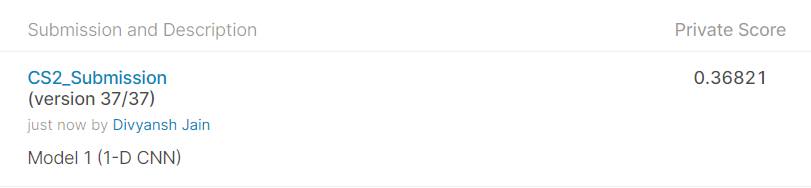

### Observation:
Train LWLRAP: 0.546 <br>
Validation LWLRAP: 0.492 <br>
Test LWLRAP: 0.368 <br><br>

### Conclusion:
The testing LWLRAP is significantly better than the baseline model's LWLRAP which means the model has decent prediction power. However, it is slighly lower than the train and validation LWLRAP, this could be due to test set differing from the curated training dataset.

## Model 2: CNN 2-D (Mel Frequency features)

### Train Cross Validation Split
We perform a 75-25 train cross validate split which is not random, but, stratified such that both train and validation dataset contain approximately the same distribution of number of labels per clip

In [2]:
ALL_FILES_DIRECTORY = r'all_data/'
TRAIN_FILES_DIRECTORY = r'train_data/'
VAL_FILES_DIRECTORY = r'val_data/'

train_csv_path = r'df_train.csv'
val_csv_path   = r'df_val.csv'
class_map_path = r'class_map.csv'

In [3]:
def count_labels(label_string):
    '''
    Descrption -> Returns the total count of labels in the given comma separated label_string
    Input -> String containing all the labels corr. the clip in CSV format ("label1,label2,label3")
    Output -> Number of unique labels in the label_string (eg. 3)
    '''
    return len(label_string.split(','))

In [4]:
df_combined = pd.read_csv(r'train_curated.csv')
df_combined['label_count'] = df_combined['labels'].apply(count_labels)

In [10]:
df_combined['label_count'].value_counts()

1    4269
2     627
3      69
4       4
6       1
Name: label_count, dtype: int64

In [12]:
# There is only one point with 6 labels which can be considered as an outlier hence we delete the corresponding clip
fname_to_be_deleted = (df_combined[df_combined['label_count'] == 6]['fname']).values[0]
fname_path = ALL_DATA + fname_to_be_deleted
os.remove(fname_path)
df_combined = df_combined[df_combined['label_count'] < 6]
y_count=np.array(df_combined['label_count'])
df_train, df_val = train_test_split(df_combined, stratify=y_count, test_size=0.25, random_state=21)

In [16]:
df_combined['label_count'].value_counts()/(sum(df_combined['label_count'].value_counts().values))*100

1    85.912658
2    12.618233
3     1.388609
4     0.080499
Name: label_count, dtype: float64

In [17]:
df_train['label_count'].value_counts()/(sum(df_train['label_count'].value_counts().values))*100

1    85.909823
2    12.614063
3     1.395598
4     0.080515
Name: label_count, dtype: float64

In [18]:
df_val['label_count'].value_counts()/(sum(df_val['label_count'].value_counts().values))*100

1    85.921158
2    12.630732
3     1.367659
4     0.080451
Name: label_count, dtype: float64

#### We observe that both the training and validation dataframes have the same distribution of label counts

In [19]:
# Keeping only the original columns and dropping the newly added 'label_count' column
df_train=df_train[['fname', 'labels']]
df_train.to_csv('df_train.csv', index=False)
df_val=df_val[['fname', 'labels']]
df_val.to_csv('df_val.csv', index=False)

In [21]:
# Moving the .wav files present in df_val to the VAL_FILES_DIRECTORY
df_val_filenames = set(df_val['fname'])
all_files = os.listdir(ALL_FILES_DIRECTORY)
for file in all_files:
    if file in df_val_filenames:
        src_path = os.path.join(ALL_FILES_DIRECTORY, file)
        dst_path = os.path.join(VAL_FILES_DIRECTORY, file)
        shutil.move(src_path, dst_path)
os.rename(ALL_FILES_DIRECTORY, TRAIN_FILES_DIRECTORY)

In [22]:
# Config class is used to share global parameters across various functions
class Config():
    def __init__(self, sampling_rate, n_classes=80):
        self.sampling_rate=sampling_rate
        self.n_classes=n_classes
        self.stft_window_seconds=0.025
        self.stft_hop_seconds=0.010
        self.mel_bands=96
        self.mel_min_hz=20
        self.mel_max_hz=20000
        self.mel_log_offset=0.001
        self.example_window_seconds=1.0
        self.example_hop_seconds=0.5

In [23]:
# All input clips use a 44.1 kHz sample rate.
SAMPLE_RATE = 44100
config = Config(SAMPLE_RATE)

### Input Pipeline (creation of train and validation datasets)

Inspiration for the below featurizations has been taken from the research paper: https://arxiv.org/pdf/1906.02975v4.pdf

In [24]:
def clip_to_waveform(clip, clip_dir=None):
    """
    Description -> Decodes a WAV clip into a waveform tensor where the values lie in [-1, +1]
    Inputs->
        clip -> .wav file eg. file1.wav
        clip_dir -> Parent folder in which the above clips is stored, for eg., "TRAIN_DIR"
    Output -> Tensor corrsponding to the clip with all values between -1 to 1
    """
    clip_path = tf.strings.join([clip_dir, clip], separator=os.sep)
    clip_data = tf.io.read_file(clip_path)
    waveform, sr = tf.audio.decode_wav(clip_data)
    return tf.squeeze(waveform)

def clip_to_log_mel_examples(clip, clip_dir=None):
    """
    Description -> Decodes a WAV clip into a batch of log mel spectrum examples
    This function takes the given .wav file, gets it tensor representation, converts it into spectrogram using short-time
    Fourier transform, then converts the spectrogram into log mel spectrogram, finally, it divides it into various windows
    and returns all the windows in a 3-channel format
    
    Inputs->
        clip -> .wav file eg. file1.wav
        clip_dir -> Parent folder in which the above clips is stored, for eg., "TRAIN_DIR"
        
    Output -> Log mel spectrogram windowed features
    """
    # Decode WAV clip into waveform tensor.
    waveform = clip_to_waveform(clip, clip_dir=clip_dir)

    # Convert waveform into spectrogram using a Short-Time Fourier Transform.
    # Note that tf.signal.stft() uses a periodic Hann window by default.
    window_length_samples = int(round(config.sampling_rate * config.stft_window_seconds))
    hop_length_samples = int(round(config.sampling_rate * config.stft_hop_seconds))
    fft_length = 2 ** int(np.ceil(np.log2(window_length_samples)))
    
    magnitude_spectrogram = tf.math.abs(tf.signal.stft(signals=waveform,
                                                       frame_length=window_length_samples,
                                                       frame_step=hop_length_samples,
                                                       fft_length=fft_length))

    # Convert spectrogram into log mel spectrogram.
    num_spectrogram_bins = fft_length // 2 + 1
    linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(num_mel_bins=config.mel_bands,
                                                                        num_spectrogram_bins=num_spectrogram_bins,
                                                                        sample_rate=config.sampling_rate,
                                                                        lower_edge_hertz=config.mel_min_hz,
                                                                        upper_edge_hertz=config.mel_max_hz)
    mel_spectrogram = tf.matmul(magnitude_spectrogram, linear_to_mel_weight_matrix)
    log_mel_spectrogram = tf.math.log(mel_spectrogram + config.mel_log_offset)

    # Frame log mel spectrogram into examples.
    spectrogram_sr = 1 / config.stft_hop_seconds
    example_window_length_samples = int(round(spectrogram_sr * config.example_window_seconds))
    example_hop_length_samples = int(round(spectrogram_sr * config.example_hop_seconds))
    features = tf.signal.frame(signal=log_mel_spectrogram,
                               frame_length=example_window_length_samples,
                               frame_step=example_hop_length_samples,
                               pad_end=True,
                               pad_value=0.0,
                               axis=0)
    
    # Converting mono channel to 3 channels
    features=tf.stack([features,features,features], axis=-1)
    return features

def record_to_labeled_log_mel_examples(csv_record,
                                       clip_dir=None,
                                       label_class_index_table=None,
                                       num_classes=None):
    """
    Description -> Creates a batch of log mel spectrum examples from a training record.

    Inputs ->
    csv_record: a line from a training CSV file downloaded from Kaggle
    clip_dir: path to a directory containing clips referenced by csv_record
    label_class_index_table: a lookup table that represents the class map
    num_classes: number of classes in the class map

    Output ->
    features: Tensor containing a batch of log mel spectrum examples
    labels: Tensor containing corresponding labels in 1-hot format
    
    """
    # clip is the filename such as "filename1.wav"
    # labels_str is the string of all labels corresponding to that filename eg., "bike,vroom,accelarate"
    [clip, labels_str] = tf.io.decode_csv(csv_record, record_defaults=[[''],['']])
    
    # features are the windowed log mel spectrogram examples
    features = clip_to_log_mel_examples(clip, clip_dir=clip_dir)
    
    # num_examples are the total number of windows
    num_examples = tf.shape(features)[0]
    
    # We split all the labels by comma
    clip_labels = tf.strings.split([labels_str], sep=',').values
    
    # Obtain the corresponding indices from the lookup table
    class_indices = label_class_index_table.lookup(clip_labels)
    
    # One Hot Encode the class_indices
    label_onehots = tf.one_hot(indices=class_indices, depth=num_classes)
    label_multihot = tf.math.reduce_max(label_onehots, axis=[0], keepdims=False)
    
    # Adjust the dimensionality of the OHE labels
    labels = tf.tile([label_multihot], [num_examples, 1])

    return features, labels

def get_class_map(class_map_path):
    """
    Description -> Constructs a class label lookup table from a class map
    
    Input ->
    class_map_path: Path to the class_map.csv file which contains the mapping of each unqiue class label to an integer from 0-79
    
    Output ->
    label_class_index_table: Lookup table mapping each class label to a unique integer
    num_classes: Total number of unique classes
    """
    label_class_index_table = tf.lookup.StaticHashTable(tf.lookup.TextFileInitializer(filename=class_map_path,
                                                                                      key_dtype=tf.string,
                                                                                      key_index=1,
                                                                                      value_dtype=tf.int32,
                                                                                      value_index=0,
                                                                                      delimiter=','),
                                                        default_value=-1)
    num_classes = len(open(class_map_path).readlines())
    return label_class_index_table, num_classes

In [25]:
# Get the lookup table
label_class_index_table, num_classes = get_class_map(class_map_path)

# Read the filename and corr. class labels from input csv files
train_dataset = tf.data.TextLineDataset(train_csv_path)
# Skip the header row
train_dataset = train_dataset.skip(1)

val_dataset = tf.data.TextLineDataset(val_csv_path)
val_dataset = val_dataset.skip(1)

In [26]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.map(lambda x: record_to_labeled_log_mel_examples(x,
                                                                               clip_dir=TRAIN_FILES_DIRECTORY,
                                                                               label_class_index_table=label_class_index_table,
                                                                               num_classes=num_classes),
                                  num_parallel_calls=AUTOTUNE)

val_dataset = val_dataset.map(lambda x: record_to_labeled_log_mel_examples(x,
                                                                           clip_dir=VAL_FILES_DIRECTORY,
                                                                           label_class_index_table=label_class_index_table,
                                                                           num_classes=num_classes),
                              num_parallel_calls=AUTOTUNE)

In [22]:
c=0
for i in train_dataset:
    print("Shape of data = ", tf.shape(i[0]))
    print("Shape of class label = ", tf.shape(i[1]))
    print()
    c+=1
    if c==3: break

Shape of data =  tf.Tensor([ 60 100  96   3], shape=(4,), dtype=int32)
Shape of class label =  tf.Tensor([60 80], shape=(2,), dtype=int32)

Shape of data =  tf.Tensor([ 34 100  96   3], shape=(4,), dtype=int32)
Shape of class label =  tf.Tensor([34 80], shape=(2,), dtype=int32)

Shape of data =  tf.Tensor([ 36 100  96   3], shape=(4,), dtype=int32)
Shape of class label =  tf.Tensor([36 80], shape=(2,), dtype=int32)



The current train_dataset consists of tensors of shape:<br>
(a1, 100, 96, 3)<br>
(a2, 100, 96, 3)<br>
.<br>
.<br>
.<br>
<br>
To train a model, we'll need a1=a2=..., so we unbatch all the frames and then again rebatch in batches of 64 so that we've a uniform shape of (64, 100, 96, 3) which we can provide as an input to the model

In [29]:
# Unbatch all the examples and then again batch these to create uniform batches of size 64, load these into cache for faster
# execution, shuffle these to ensure randomized inputs to each epoch and prefetch to ensure GPU is not idle
batch_size = 64
train_dataset=train_dataset.unbatch()
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.cache().shuffle(buffer_size=905, seed=21).prefetch(AUTOTUNE)

val_dataset=val_dataset.unbatch()
val_dataset = val_dataset.batch(batch_size)
val_dataset= val_dataset.cache().shuffle(buffer_size=325, seed=21).prefetch(AUTOTUNE)

In [25]:
c=0
for i in train_dataset:
    if c==3: break
    print("Shape of data = ", tf.shape(i[0]))
    print("Shape of class label = ", tf.shape(i[1]))
    c+=1

Shape of data =  tf.Tensor([ 64 100  96   3], shape=(4,), dtype=int32)
Shape of class label =  tf.Tensor([64 80], shape=(2,), dtype=int32)
Shape of data =  tf.Tensor([ 64 100  96   3], shape=(4,), dtype=int32)
Shape of class label =  tf.Tensor([64 80], shape=(2,), dtype=int32)
Shape of data =  tf.Tensor([ 64 100  96   3], shape=(4,), dtype=int32)
Shape of class label =  tf.Tensor([64 80], shape=(2,), dtype=int32)


In [31]:
# Creating TF Callbacks, tensorboard_callback is to monitor logs and checkpoint is to save model weights after every epoch
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
checkpoint = ModelCheckpoint(filepath='weights_{epoch}-loss_{loss:.4f}_lwlrap_{lwlrap:.4f}.h5',
                             verbose=0, save_weights_only=True)

callbacks_list = [checkpoint, tensorboard_callback]

In [32]:
# The model used here is the MobileNet by Google
# Ref: https://stackoverflow.com/questions/41668813/how-to-add-and-remove-new-layers-in-keras-after-loading-weights
def get_2dcnn_model(weights_path=None):
    '''
    Description -> Return the 2D CNN Model
    
    Input ->
    weights_path (optional): Path to the best model weights (used at testing time)
    
    Output -> Model instance
    
    It returns the compiled model which will be used for training if no "weights_path" is supplied, else, it returns the model
    with best weights found during training which will be used during testing phase
    '''
    source_model = MobileNet(include_top=False, input_shape=(100, 96, 3))
    x = Flatten()(source_model.layers[-1].output)
    out = Dense(80)(x)
    model = Model(inputs=source_model.input, outputs=out)
    if not weights_path:
        model.compile(optimizer='adam',
                      loss=tf.nn.sigmoid_cross_entropy_with_logits,
                      metrics=[LWLRAP(80)])
    else:
        model.load_weights(weights_path)
        
    return model

In [30]:
model = get_2dcnn_model()
model.summary()

17227776/17225924 [==============================] - 0s 0us/step
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 96, 3)]      0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 101, 97, 3)        0         
_________________________________________________________________
conv1 (Conv2D)               (None, 50, 48, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 50, 48, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 50, 48, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 50, 48, 32)        288       
_______________________________________________________

In [31]:
model.fit(train_dataset,
          validation_data=val_dataset,
          callbacks=callbacks_list,
          verbose=2,
          epochs=11)

Epoch 1/11
902/902 - 305s - loss: 0.0747 - lwlrap: 0.2353 - val_loss: 0.0621 - val_lwlrap: 0.3342
Epoch 2/11
902/902 - 129s - loss: 0.0597 - lwlrap: 0.3656 - val_loss: 0.0653 - val_lwlrap: 0.3497
Epoch 3/11
902/902 - 129s - loss: 0.0535 - lwlrap: 0.4410 - val_loss: 0.0560 - val_lwlrap: 0.4238
Epoch 4/11
902/902 - 133s - loss: 0.0489 - lwlrap: 0.5066 - val_loss: 0.0649 - val_lwlrap: 0.4006
Epoch 5/11
902/902 - 129s - loss: 0.0446 - lwlrap: 0.5606 - val_loss: 0.0618 - val_lwlrap: 0.4305
Epoch 6/11
902/902 - 128s - loss: 0.0413 - lwlrap: 0.6015 - val_loss: 0.0795 - val_lwlrap: 0.3591
Epoch 7/11
902/902 - 127s - loss: 0.0373 - lwlrap: 0.6536 - val_loss: 0.0701 - val_lwlrap: 0.4216
Epoch 8/11
902/902 - 127s - loss: 0.0330 - lwlrap: 0.7004 - val_loss: 0.0667 - val_lwlrap: 0.4563
Epoch 9/11
902/902 - 125s - loss: 0.0291 - lwlrap: 0.7428 - val_loss: 0.0518 - val_lwlrap: 0.5205
Epoch 10/11
902/902 - 126s - loss: 0.0253 - lwlrap: 0.7868 - val_loss: 0.0556 - val_lwlrap: 0.5199
Epoch 11/11
902/902

### Cross validation curve for 2-D CNN Model

### Loss curve

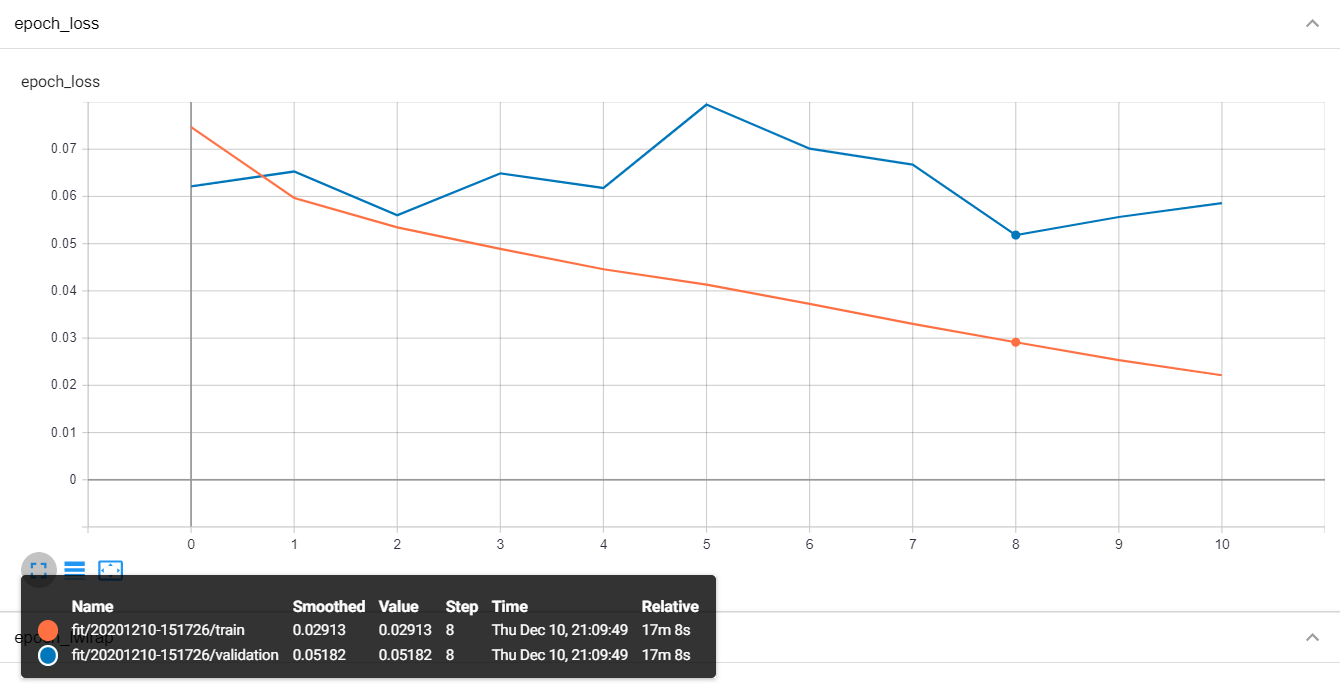

### LWLRAP Curve

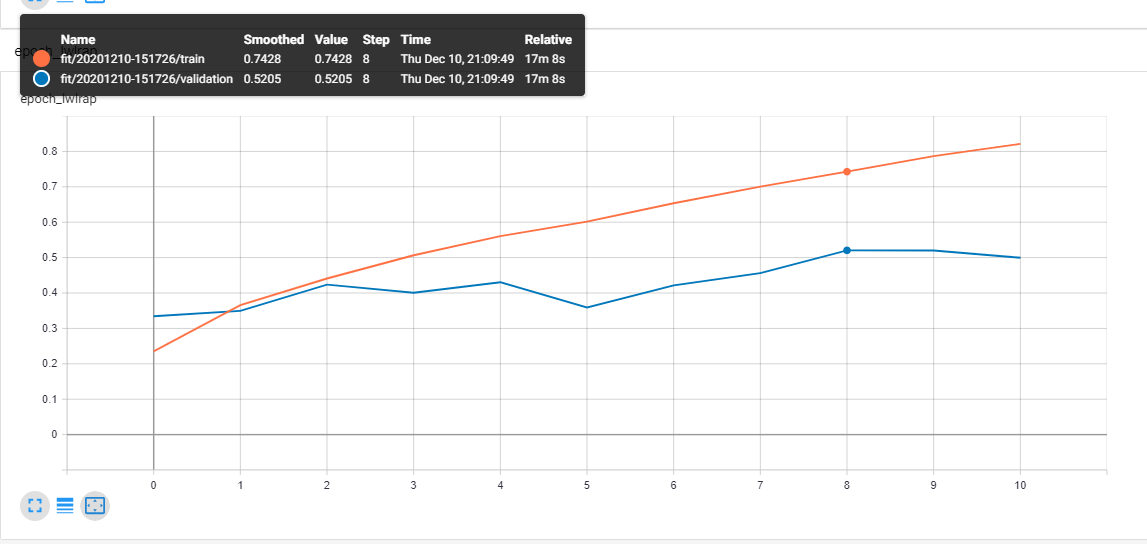

We get sufficiently good validation performance after 9 epochs, also, the difference between the train and validation scores is not very high, so, we are sure that the model is not overfitting.

## Performance on test dataset

In [28]:
TEST_DIR = r'test_data/'
df_test = pd.read_csv(r'sample_submission.csv')
test_csv_path = r'sample_submission.csv'

### Preparing test_dataset

In [29]:
def get_test_file_name(full_csv_string):
    '''
    Description -> Returns the filename ('filename1.wav') from the complete csv record ("filename1.wav,label1,label2,..label80")
    Input -> The complete csv_record read from sample_submission.csv file
    Output -> Extracted filename of the clip ('filename1.wav')
    '''
    return tf.strings.split(full_csv_string, sep=r',')[0]

In [30]:
test_dataset = tf.data.TextLineDataset(test_csv_path)
test_dataset = test_dataset.skip(1)
test_dataset=test_dataset.map(get_test_file_name)

test_dataset = test_dataset.map(lambda x: clip_to_log_mel_examples(x,
                                                                   clip_dir=TEST_DIR),
                                num_parallel_calls=AUTOTUNE)

In [31]:
# Each clip is windowed into several examples of varying sizes which we unbatch and again batch into uniform sized batches
# But, we need to keep track of the number of windows for each example as these will be helpful in the end when we will average
# the outcomes of all the examples
clip_sizes=[None]*len(os.listdir(TEST_DIR))
i=0
for clip in test_dataset:
    clip_sizes[i]=(tf.shape(clip)[0]).numpy()
    i+=1

In [32]:
model = get_2dcnn_model(r'weights_9-loss_0.0291_lwlrap_0.7428.h5')

In [14]:
predictions=model.predict(test_dataset, verbose=1)

3361/3361 [==============================] - 593s 176ms/step


In [15]:
# Converting the model's outputs to prob. values between 0 and 1 using Sigmoid function
predictions_sigmoid = 1/(1 + np.exp(-predictions))

In [33]:
def averaged_prediction(label_idx, start_idx):
    '''
    Description ->
    The model predicts the probabilities for each of the 80 classes for each window, but, for final predictions we need to
    combine the predictions for all windows of a given clip so that we get y_pred to be of the same size as number of clips
    in the test dataset
    
    Inputs ->
    label_idx: Index corr. to the current clip being processed, this is used to obtain the total number of windows in the given
    clip using the earlier computed "clip_sizes" list
    
    start_idx: Index of the first window in the predictions from which the averaging has to start for the given clip
    The average is computed from start_idx upto (start_idx + clip_size) which acts like end_idx
    
    Output ->
    end_idx: The index of the last window of the given clip (which acts like the starting index of the next clip)
    avg: Averaged predictions of all windows corr. to a particular clip from start_idx till end_idx
    '''
    size=clip_sizes[label_idx]
    end_idx=start_idx+size
    df=predictions_sigmoid[start_idx:end_idx]
    avg=np.average(df, axis=0)
    return end_idx, avg

In [34]:
test_dataset_size=len(clip_sizes)
predictions_final=np.zeros((test_dataset_size, config.n_classes))
start_idx=0
for label_idx in range(test_dataset_size):
    start_idx, predictions_final[label_idx] = averaged_prediction(label_idx, start_idx)

In [35]:
df_test.iloc[:, 1:] = predictions_final

In [36]:
df_test.head()

,fname,Accelerating_and_revving_and_vroom,Accordion,Acoustic_guitar,Applause,Bark,Bass_drum,Bass_guitar,Bathtub_(filling_or_washing),Bicycle_bell,...,Toilet_flush,Traffic_noise_and_roadway_noise,Trickle_and_dribble,Walk_and_footsteps,Water_tap_and_faucet,Waves_and_surf,Whispering,Writing,Yell,Zipper_(clothing)
0,4260ebea.wav,0.000045,0.000099,0.001728,0.000144,0.001175,0.001660,0.000034,0.029919,0.003223,...,0.100555,0.000229,0.323414,0.001683,0.049350,0.000723,0.001828,0.008303,0.000393,0.018412
1,426eb1e0.wav,0.000084,0.000005,0.000003,0.894166,0.000440,0.000066,0.000002,0.000175,0.002628,...,0.000129,0.006841,0.002670,0.000737,0.000019,0.001283,0.000102,0.000123,0.000036,0.000099
2,428d70bb.wav,0.000920,0.001011,0.003619,0.007204,0.008988,0.004023,0.000168,0.013827,0.013958,...,0.029190,0.002779,0.009962,0.005733,0.012128,0.002960,0.047745,0.006543,0.025462,0.022797
3,4292b1c9.wav,0.000106,0.000238,0.000393,0.006113,0.043979,0.000898,0.003302,0.000355,0.001006,...,0.004895,0.003293,0.014764,0.003972,0.001366,0.000003,0.000733,0.002593,0.006002,0.000543
4,429c5071.wav,0.001094,0.000096,0.001407,0.000497,0.012905,0.037327,0.000848,0.003218,0.003100,...,0.008060,0.001905,0.020074,0.114127,0.008279,0.008655,0.005131,0.020177,0.000466,0.035189


In [37]:
df_test.to_csv('submissions.csv', index=False)

### Test Score

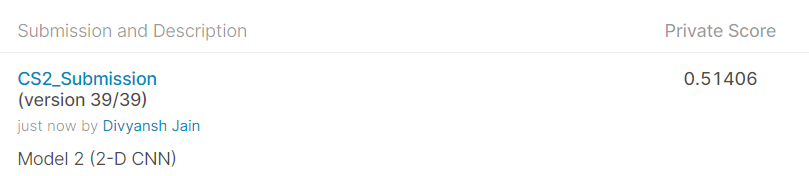

### Observations:
Training LWLRAP = 0.743 <br>
Validation LWLRAP = 0.52 <br>
Testing LWLRAP = 0.514

### Conclusion

The 2-D CNN (MobileNet) model performs very well as compared to the previous model. The difference between training and validation LWLRAP is not too high. Also, the validation and test score are also very similar which indicates the model is performing well on unseen data as well. Hence, we consider this as our final model.